# Deep Learning

## HW1- problem 2- Support Vector Machine (100 + 10 pts)

### Please fill this part


1.   Full Name: Motahare Hazrati 
2.   Student Number: 400206613


*You are just allowded to change those parts that start with "TO DO". Please do not change other parts.*

*It is highly recommended to read each codeline carefully and try to understand what it exactly does. Best of luck and have fun!*

In [1]:
# You are not allowed to import other packages.
import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC

import cvxopt

#### About the Data:
Heart diseases, also known as [Cardiovascular diseases (CVDs)](https://en.wikipedia.org/wiki/Cardiovascular_disease), are the first cause of death worldwide, taking an estimated 17.9 million lives each year which is about 32% of all deaths all over the world. 

In the present HomeWork, we are going to implement Support Vector Machines (SVM) algorithm that determines which patient is in danger and which is not.

For this perpose, `Heart_Disease_Dataset.csv` file can be used that is attached to the HomeWork folder. Use `Dataset_Description.pdf` for more detail.


In [14]:
df = pd.read_csv("./data/Heart_Disease_Dataset.csv") 
df.columns.values

array(['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol',
       'fasting blood sugar', 'resting ecg', 'max heart rate',
       'exercise angina', 'oldpeak', 'ST slope', 'target'], dtype=object)

In [15]:
mean=df['max heart rate'].mean()
std= df['max heart rate'].std()
z = (df['max heart rate']-mean)/std
dftmp= df[["age","resting bp s","cholesterol","max heart rate"]]
df_zscore = (dftmp - dftmp.mean())/dftmp.std()
df_zscore
df.loc[df['target'] == 0]

age  sex  chest pain type  resting bp s  cholesterol  \
0      40    1                2           140          289   
2      37    1                2           130          283   
4      54    1                3           150          195   
5      39    1                3           120          339   
6      45    0                2           130          237   
...   ...  ...              ...           ...          ...   
1175   56    1                2           130          221   
1176   56    1                2           120          240   
1178   55    0                2           132          342   
1182   41    1                2           120          157   
1189   38    1                3           138          175   

      fasting blood sugar  resting ecg  max heart rate  exercise angina  \
0                       0            0             172                0   
2                       0            1              98                0   
4                       0            0             122                0   
5                       0            0             170                0   
6                       0            0             170                0   
...                   ...          ...             ...              ...   
1175                    0            2             163                0   
1176                    0            0             169                0   
1178                    0            0             166                0   
1182                    0            0             182                0   
1189                    0            0             173                0   

      oldpeak  ST slope  target  
0         0.0         1       0  
2         0.0         1       0  
4         0.0         1       0  
5         0.0         1       0  
6         0.0         1       0  
...       ...       ...     ...  
1175      0.0         1       0  
1176      0.0         3       0  
1178      1.2         1       0  
1182      0.0         1       0  
1189      0.0         1       0  

[561 rows x 12 columns]

### Pre-Processing - (40 pts)

#### Exploratory Data Analysis (EDA):
In statistics, exploratory data analysis is an approach to analyze datasets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

This is a general approach that should be applied when you encounter a dataset.

shape of dataset is:  (1190, 12)
----------------------------------
this dataset has not missing value:
Number of missing values
age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64
----------------------------------
ballanced: True
Number of Zero targets are:  561
Number of One targets are:  629
Difference is:  68
--------------------- Plots --------------------------


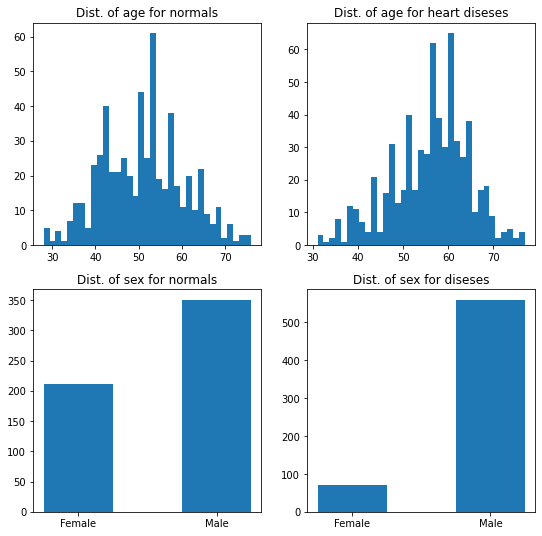

In [16]:
###############################################################################
## TODO: Find the shape of the dataset.                                      ##
###############################################################################
shape = df.shape
print("shape of dataset is: " , shape)
print('----------------------------------')
###############################################################################
## TODO: Check if there is missing entries in the dataset columnwise.        ##
###############################################################################

missings = (df[df.columns.values].isnull().sum())
print("this dataset has not missing value:")
print('Number of missing values')
print(missings)
print('----------------------------------')
###############################################################################
## TODO: Check whether the dataset is balanced or not.                       ##
## If the difference between 2 classes was less than 100 for our dataset,    ##
## it is called "ballanced".                                                 ##
###############################################################################
zeros_target= df['target'].value_counts()[0]
one_target=df['target'].value_counts()[1]

print("ballanced: True")
print("Number of Zero targets are: ",zeros_target )
print("Number of One targets are: ",one_target )
print("Difference is: ", abs(one_target-zeros_target) )
###############################################################################
## TODO: plot the age distirbution and gender distrbution for both normal    ##
## and heart diseses patients.(4 plots)                                      ##
###############################################################################
print("--------------------- Plots --------------------------")
normal_patients=df.loc[df['target'] == 0]
diseses_patients=df.loc[df['target'] == 1]
fig, ax = plt.subplots(2,2,figsize=(9, 9))
ax = ax.ravel()
# age plots
n_bins= 35
ax[0].title.set_text('Dist. of age for normals')
ax[0].hist(normal_patients['age'], bins = n_bins)
ax[1].title.set_text('Dist. of age for heart diseses')
ax[1].hist(diseses_patients['age'], bins = n_bins)
# gender plots
labels = ['Male', 'Female']
x = [1, 0]  # the label locations
rects1 = ax[2].bar(x , list(normal_patients['sex'].value_counts()), 0.5)
ax[2].set_title('Dist. of sex for normals')
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)

rects1 = ax[3].bar(x , list(diseses_patients['sex'].value_counts()), 0.5)
ax[3].set_title('Dist. of sex for diseses')
ax[3].set_xticks(x)
ax[3].set_xticklabels(labels)


# Show plot
plt.show()



#### Question 1: What do you conclude from the plots?
#### Answer: the distribution for normal people and hear diseases people are diffrent. The graph for heart disease people is skewed to the right. It can be understood from the graphs below that the data has been collected from more men than women and Men are more prone to heart disease.

#### Outlier Detection & Removal:
We will filter ouliers using Z-test.

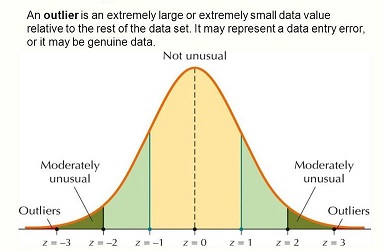

Z-test formula:
\begin{equation*}
    Z = \bigg|\frac {x - mu} {std}\bigg|
\end{equation*}

In [17]:
################################################################################
## TODO: Suppose that, based on our prior knowledge, we know some columns have##
## outliers. Calculate z-score for each featuer and determine the outliers    ##
## with threshold=3, then eliminate them. Target dataframe has(1173,12)shape. ##
################################################################################
columns = ["age","resting bp s","cholesterol","max heart rate"]
threshold = 3
dftmp= df[["age","resting bp s","cholesterol","max heart rate"]]
df_zscore = (dftmp - dftmp.mean())/dftmp.std()
df_isoutlayer =  ((abs(df_zscore)>threshold).sum(axis=1)) > 0
newdf = df
newdf['is outlayer'] = df_isoutlayer
newdf = newdf.loc[df['is outlayer'] == False]
newdf= newdf.drop(columns=['is outlayer'])
df= newdf
df.shape
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

(1173, 12)

#### Feature Engineering:
Sometimes the collected data are raw; they are either incompatible with your model or hinders its performance. That’s when feature engineering comes to rescue. It encompasses preprocessing techniques to compile a dataset by extracting features from raw data.


In [18]:
################################################################################
## TODO: Normalize numerical features to be between 0 and 1                   ##
## Note that just numerical fetures should be normalized. type of features is ##
## determined in dataset description file.                                    ##
################################################################################
numeric_columns = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']
df[numeric_columns]=(df[numeric_columns]- df[numeric_columns].min())/(df[numeric_columns].max() - df[numeric_columns].min()) 
df
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

age  sex  chest pain type  resting bp s  cholesterol  \
0     0.244898    1                2      0.571429     0.588595   
1     0.428571    0                3      0.761905     0.366599   
2     0.183673    1                2      0.476190     0.576375   
3     0.408163    0                4      0.552381     0.435845   
4     0.530612    1                3      0.666667     0.397149   
...        ...  ...              ...           ...          ...   
1185  0.346939    1                1      0.285714     0.537678   
1186  0.816327    1                4      0.609524     0.393075   
1187  0.591837    1                4      0.476190     0.266802   
1188  0.591837    0                2      0.476190     0.480652   
1189  0.204082    1                3      0.552381     0.356415   

      fasting blood sugar  resting ecg  max heart rate  exercise angina  \
0                       0            0        0.777778                0   
1                       0            0        0.659259                0   
2                       0            1        0.229630                0   
3                       0            0        0.303704                1   
4                       0            0        0.407407                0   
...                   ...          ...             ...              ...   
1185                    0            0        0.481481                0   
1186                    1            0        0.548148                0   
1187                    0            0        0.355556                1   
1188                    0            2        0.792593                0   
1189                    0            0        0.785185                0   

       oldpeak  ST slope  target  
0     0.295455         1       0  
1     0.409091         2       1  
2     0.295455         1       0  
3     0.465909         2       1  
4     0.295455         1       0  
...        ...       ...     ...  
1185  0.431818         2       1  
1186  0.681818         2       1  
1187  0.431818         2       1  
1188  0.295455         2       1  
1189  0.295455         1       0  

[1173 rows x 12 columns]

### SVM - (60 pts)

#### spliting data

In [19]:
# The original dataset labels is 0 and 1 and in the following code we change it to -1 and 1. 
df.target.replace(0 , -1 , inplace = True) 

# Turn pandas dataframe to numpy array type
df = df.to_numpy()

# Splitting data into train and test part. 70% for train and 30% for test
train = df[:int(len(df) * 0.7)]
test = df[int(len(df) * 0.7):]

# Getting features 
X_train = train[: , :-1]
y_train = train[: , -1]

# Getting labels
X_test = test[: , :-1]
y_test = test[: , -1]

# shapes should be: 
# Train: (821, 11) (821,)
# Test: (352, 11) (352,)
print("Train: ", X_train.shape ,y_train.shape)
print("Test: " ,X_test.shape ,y_test.shape)


Train:  (821, 11) (821,)
Test:  (352, 11) (352,)


#### SVM Using sklearn:
Use the standard libarary SVM classifier (SVC) on the training data, and then test the classifier on the test data. You will need to call SVM with 3 kernels: (1) Linear, (2) Polynomial and (3) RBF. You can change C to achive better results. For "RBF" find "gamma" witch takes 90% accuracy, at least. For polynomial kernel you are allowed to change "degree" to find best results.

For each kernel, reportting the followings is required:
Accuracy, Precision, Recall, F1score.

In [20]:
def classification_report(y_true, y_pred):
    #################################################################################
    ## TODO: Define a function that returns the followings:                        ##
    ## Accuracy, Precision, Recall, F1score.                                       ##
    #################################################################################
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==-1:
           TN += 1
        if y_pred[i]==-1 and y_true[i]!=y_pred[i]:
           FN += 1
    Accuracy = (TP+TN)/(TP+FP+TN+FN) 
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1score = 2* (Precision*Recall)/(Precision+Recall)
    #################################################################################
    #                                 END OF YOUR CODE                              #
    #################################################################################
    return Accuracy, Precision, Recall, F1score

In [21]:
#########################################################################################
## TODO: Use svm of sklearn package (imported above) with 3 kernels.                   ##
## You should define model, fit using X_train, predict using X_test.                   ##
## your predictions known as y_pred.                                                   ##
## then use classification_report function to evaluate model.                          ##
#########################################################################################

# linear kernel
clf = SVC(kernel='linear') 
clf.fit(X_train, y_train) 
y_pred= clf.predict(X_test)
print("results of sklearn svm linear kernel:", classification_report(y_test, y_pred))



# polynomial kernel
clf = SVC(kernel='poly') 
clf.fit(X_train, y_train) 
y_pred= clf.predict(X_test)
print("results of sklearn svm polynomial kernel:", classification_report(y_test, y_pred))


# rbf kernel
clf = SVC(kernel='rbf') 
clf.fit(X_train, y_train) 
y_pred= clf.predict(X_test)
print("results of sklearn svm RBF kernel:", classification_report(y_test, y_pred))


#########################################################################################
#                                      END OF YOUR CODE                                 #
#########################################################################################

results of sklearn svm linear kernel: (0.7869318181818182, 0.7756410256410257, 0.7515527950310559, 0.7634069400630915)
results of sklearn svm polynomial kernel: (0.7840909090909091, 0.8014184397163121, 0.7018633540372671, 0.7483443708609272)
results of sklearn svm RBF kernel: (0.7698863636363636, 0.7439024390243902, 0.7577639751552795, 0.7507692307692307)


#### SVM:
Now that you know how the standard library SVM works on the dataset, attempt to implement your own version of SVM. Implement SVM using Quadratic Programming(QP) approach. Remember that SVM objective fuction with QP is:

\begin{equation*}
    min_{\alpha}\quad\frac{1}{2}\alpha^T\,Q\,\alpha-1^T\,\alpha\\
    s.t.\qquad y^T\,\alpha=0,\,\alpha\ge0
\end{equation*}

where:
\begin{equation*}
    Q_{i,j}=y_i\,y_j\,\langle x_i\,,\,x_j\rangle
\end{equation*}

and:
\begin{equation*}
    \text{if}\;(\alpha_n>0)\;\text{then}\;x_n\;\text{is a  support vector}
\end{equation*}

For this perpose, complete the following code. You are allowed to use "cvxopt" package. It's an optimization package for Quadratic Programming. Below is the user's guide for the QP from CVXOPT:

[Quadratic Programming](https://cvxopt.org/userguide/coneprog.html#quadratic-programming)

In [33]:
# Hide cvxopt output
cvxopt.solvers.options["show_progress"] = False

#####################################################################################
## TODO: Use the information from the lecture slides to formulate the SVM          ##
## kernels. These kernel functions will be called in the SVM class.                ##
#####################################################################################

def linear_kernel(x1, y1):
    lk=np.dot(x1, y1)
    return lk

def polynomial_kernel(x, y, p=3):
    pl=(1 + np.dot(x, y)) ** p
    return pl

def rbf_kernel(self, x, y, gamma=0.5):
    rbf=np.exp(-gamma*linalg.norm(x - y) ** 2 )
    return rbf

#####################################################################################
#                                   END OF YOUR CODE                                #
#####################################################################################


class MySVM(object):
    def __init__(self, kernel=linear_kernel):
            self.kernel = kernel
            self.C = 2
            self.gamma = 5
            self.degree = 5
    def linear_kernel(self, x1, x2):
        return np.dot(x1, x2)

    def polynomial_kernel(self, x, y,C=1, d=3):
        return (np.dot(x, y) + C) **d 

    def rbf_kernel(self, x, y, gamma=0.5):
        return np.exp(-gamma*np.linalg.norm(x - y) ** 2 )


    

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                if self.kernel == 'linear':
                    K[i, j] = self.linear_kernel(X[i], X[j])
                if self.kernel=='rbf':
                    K[i, j] = self.rbf_kernel(X[i], X[j], self.gamma)   
                    self.C = None  
                if self.kernel == 'polynomial':
                    K[i, j] = self.polynomial_kernel(X[i], X[j], self.C, self.degree)


        # Converting into cvxopt format:
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None or self.C==0:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            # Restricting the optimisation with parameter C.
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # Setting options:
        cvxopt.solvers.options['show_progress'] = True
        cvxopt.solvers.options['abstol'] = 1e-10
        cvxopt.solvers.options['reltol'] = 1e-10
        cvxopt.solvers.options['feastol'] = 1e-10

        # Solve QP problem:
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        alphas = np.ravel(solution['x'])        # Flatten the matrix into a vector of all the Langrangian multipliers.

        # Support vectors have non zero lagrange multipliers
        sv = alphas > 1e-5
        #this will actually give the indices of the support vectors
        ind = np.arange(len(alphas))[sv]
        # get alphas of support vector , Xs and ys too.
        self.alphas = alphas[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]

        # intercept
        self.b = 0
        for n in range(len(self.alphas)):
            # For all support vectors:
            self.b += self.sv_y[n]
            self.b -= np.sum(self.alphas * self.sv_y * K[ind[n], sv])
        self.b = self.b / len(self.alphas)

        # Weight vector
        if self.kernel == 'linear':
            self.w = np.zeros(n_features)
            for n in range(len(self.alphas)):
                self.w += self.alphas[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
        #####################################################################################
        #                                   END OF YOUR CODE                                #
        #####################################################################################
    def predict(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.alphas, self.sv_y, self.sv):

                    if self.kernel == 'linear':
                        s += a * sv_y * self.linear_kernel(X[i], sv)
                    if self.kernel=='rbf':
                        s += a * sv_y * self.rbf_kernel(X[i], sv, self.gamma)   # Kernel trick.
                        self.C = None  
                    if self.kernel == 'polynomial':
                        s += a * sv_y * self.polynomial_kernel(X[i], sv, self.C, self.degree)

                y_predict[i] = s
            return np.sign(y_predict + self.b)
        #####################################################################################
        #                                   END OF YOUR CODE                                #
        #####################################################################################
      

*italicized text*

In [34]:
###################################################################################
## TODO: define 3 model same as previous part (SVM Using sklearn) and evaluate   ##
## them. Note that for comaparing your result with that part for each kernel use ##
## same parameters in both parts.                                                ##
###################################################################################

# linear kernel
clf = MySVM(kernel='linear_kernel') 
clf.fit(X_train, y_train) 
y_pred= clf.predict(X_test)
print("results of sklearn svm linear kernel:", classification_report(y_test, y_pred))



# polynomial kernel
clf = MySVM(kernel='polynomial') 
clf.fit(X_train, y_train) 
y_pred= clf.predict(X_test)
print("results of sklearn svm polynomial kernel:", classification_report(y_test, y_pred))


# rbf kernel
clf = MySVM(kernel='rbf') 
clf.fit(X_train, y_train) 
y_pred= clf.predict(X_test)
print("results of sklearn svm RBF kernel:", classification_report(y_test, y_pred))

     pcost       dcost       gap    pres   dres
 0: -1.2177e+03 -3.5173e+03  2e+03  3e-13  6e-16
 1: -1.4257e+03 -1.5700e+03  1e+02  8e-13  1e-16
 2: -1.4660e+03 -1.4700e+03  4e+00  1e-12  5e-17
 3: -1.4680e+03 -1.4680e+03  4e-02  3e-13  2e-17
 4: -1.4680e+03 -1.4680e+03  4e-04  2e-13  2e-17
 5: -1.4680e+03 -1.4680e+03  4e-06  2e-13  4e-16
 6: -1.4680e+03 -1.4680e+03  4e-08  1e-14  2e-16
Optimal solution found.
results of sklearn svm linear kernel: (0.45738636363636365, 0.45738636363636365, 1.0, 0.6276803118908382)
     pcost       dcost       gap    pres   dres
 0: -4.2686e+01 -3.0152e+03  1e+04  1e+00  4e-08
 1: -2.9912e+01 -1.0913e+03  2e+03  2e-01  2e-08
 2: -2.3742e+01 -4.9223e+02  8e+02  6e-02  2e-08
 3: -1.6066e+01 -2.3622e+02  3e+02  2e-02  2e-08
 4: -1.3196e+01 -1.2477e+02  2e+02  9e-03  1e-08
 5: -8.5281e+00 -7.5906e+01  1e+02  3e-03  1e-08
 6: -7.0843e+00 -4.1066e+01  5e+01  1e-03  7e-09
 7: -6.8511e+00 -2.3907e+01  2e+01  4e-04  5e-09
 8: -6.9014e+00 -1.5766e+01  1e+01  2e-

In [ ]:
X_train[0]

array([0.24489796, 1.        , 2.        , 0.57142857, 0.5885947 ,
       0.        , 0.        , 0.77777778, 0.        , 0.29545455,
       1.        ])

#### Question 2: Report best results.



1.  Best kernel: 
2.  Best Accuracy: 




### Bonus Score - (10pts)

In this step you can check other kernel functions or change parameters or any idea to get better result in compare with last section's results.